In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv("anime.csv")

In [3]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [5]:
df.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [6]:
df = df.dropna(subset=['name', 'genre'])

In [7]:
# Replace missing episodes & rating with median
df['episodes'] = df['episodes'].replace('Unknown', np.nan)
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['episodes'] = df['episodes'].fillna(df['episodes'].median())

df['rating'] = df['rating'].fillna(df['rating'].median())

# Fill genre missing with empty string
df['genre'] = df['genre'].fillna("")

In [8]:
df.shape

(12232, 7)

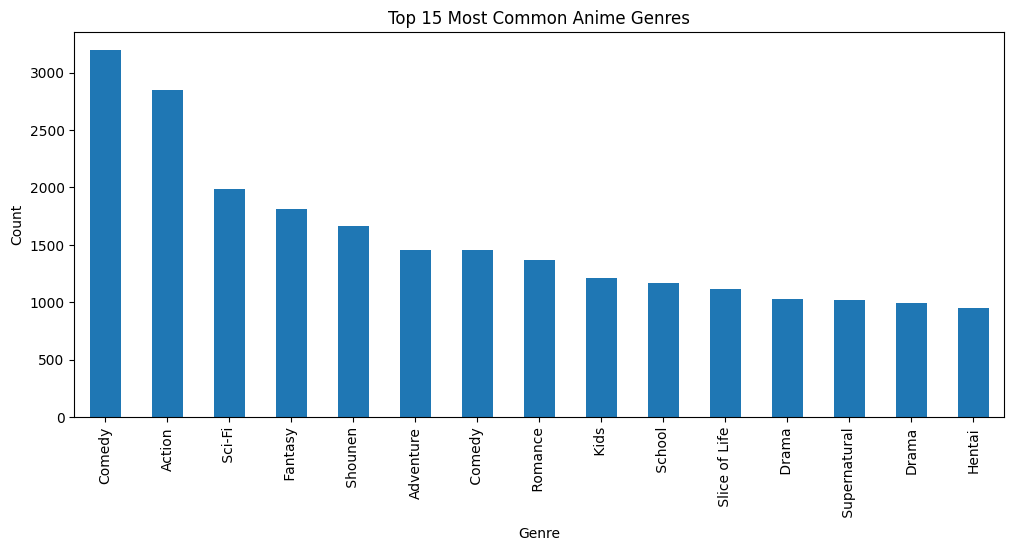

In [9]:
plt.figure(figsize=(12,5))
df['genre'].str.split(',').explode().value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Most Common Anime Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

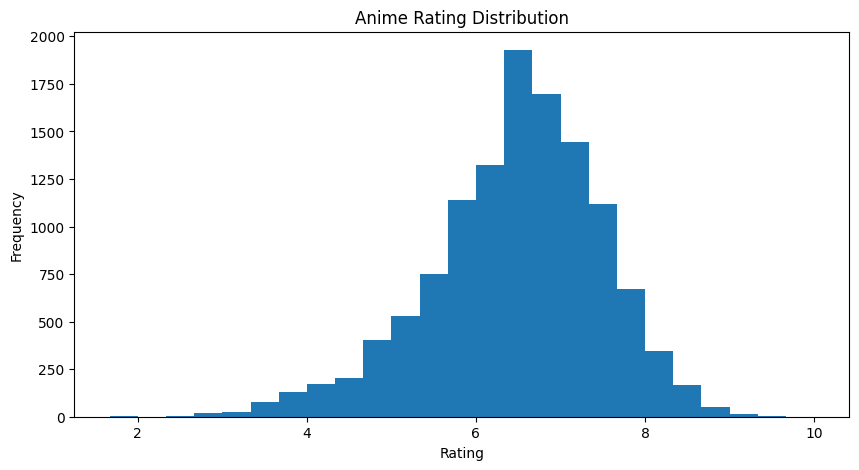

In [10]:
plt.figure(figsize=(10,5))
plt.hist(df['rating'], bins=25)
plt.title("Anime Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

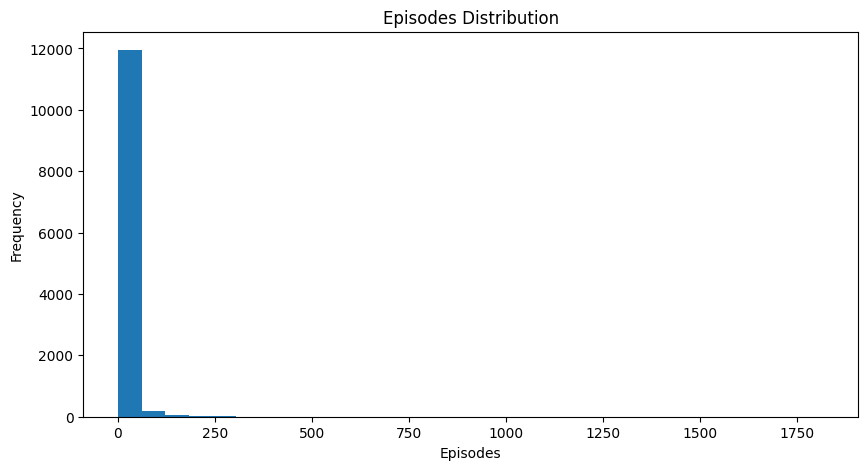

In [11]:
plt.figure(figsize=(10,5))
plt.hist(df['episodes'], bins=30)
plt.title("Episodes Distribution")
plt.xlabel("Episodes")
plt.ylabel("Frequency")
plt.show()

**Feature Extraction (Using Genres + Episodes + Rating)**

In [12]:
tfidf = TfidfVectorizer(stop_words="english")
genre_matrix = tfidf.fit_transform(df['genre'])

In [13]:
df_scaled = df[['episodes', 'rating']]
df_scaled = (df_scaled - df_scaled.min()) / (df_scaled.max() - df_scaled.min())


In [25]:
from scipy.sparse import hstack

final_features = hstack([genre_matrix, df_scaled])

In [26]:
similarity_matrix = cosine_similarity(final_features, final_features)


**Recommendation Function**

In [27]:
def recommend_anime(title, top_n=10, threshold=0.3):
    if title not in df['name'].values:
        return "Anime not found."

    idx = df.index[df['name'] == title][0]
    similarity_scores = list(enumerate(similarity_matrix[idx]))

    # Filter based on similarity threshold
    similarity_scores = [x for x in similarity_scores if x[1] >= threshold]

    # Sort by similarity (descending)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Remove the anime itself
    similarity_scores = similarity_scores[1:top_n+1]

    recommended = [(df.iloc[i]['name'], score) for i, score in similarity_scores]

    return recommended

**Test Recommendation**

In [28]:
print("\nRecommended Anime:")
result = recommend_anime("Naruto")
for name, score in result:
    print(f"{name}  --->  Similarity: {score:.3f}")


Recommended Anime:
Naruto: Shippuuden  --->  Similarity: 0.995
Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi  --->  Similarity: 0.995
Boruto: Naruto the Movie  --->  Similarity: 0.995
Naruto x UT  --->  Similarity: 0.995
Naruto: Shippuuden Movie 4 - The Lost Tower  --->  Similarity: 0.995
Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono  --->  Similarity: 0.995
Naruto Shippuuden: Sunny Side Battle  --->  Similarity: 0.994
Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!  --->  Similarity: 0.994
Rekka no Honoo  --->  Similarity: 0.962
Naruto: Shippuuden Movie 6 - Road to Ninja  --->  Similarity: 0.961


In [29]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Assume genres as "liked" behavior for evaluation
true_genres = test_df['genre'].str.split(',')


**Evaluate if recommendations share same genres**

In [35]:
def evaluate_recommendation_system():
    y_true = []
    y_pred = []

    for title in test_df['name'].head(200):  # limit due to compute
        recs = recommend_anime(title, top_n=5, threshold=0.2)

        if isinstance(recs, str):  # anime not found
            continue

        true_genre_list = df.loc[df['name'] == title, 'genre'].values[0].split(",")

        rec_genres = []
        for rec_title, _ in recs:
            rec_genres.extend(df.loc[df['name'] == rec_title, 'genre'].values[0].split(","))

        # Convert to binary format
        y_true.append(1)
        y_pred.append(1 if set(true_genre_list) & set(rec_genres) else 0)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\nEvaluation Metrics:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)


In [36]:
# Call Evaluation
evaluate_recommendation_system()


Evaluation Metrics:
Precision: 1.0
Recall: 0.475
F1-Score: 0.6440677966101694


# **1. Difference between User-based vs Item-based Collaborative Filtering**

User-based:
Recommends items liked by similar users
Example: “People like you also watched…”

Item-based:
Recommends items similar to the item you like
Example: “Similar to Naruto…”

# **2. What is Collaborative Filtering?**

It uses past user behavior (ratings, clicks, likes) to predict what users may like.

No content/genre required → only user–item matrix.